## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer=keras.layers.Input(input_shape)
    
    for i,n_units in enumerate(num_neurons):
        if i==0:
            x=keras.layers.Dense(n_units,
                                activation='relu',
                                name='hidden_layer'+str(i+1))(input_layer)
            x=BatchNormalization()(x)
        else:
            x=keras.layers.Dense(n_units,
                                activation='relu',
                                name='hidden_layer'+str(i+1))(x)
            x=BatchNormalization()(x)
    out=keras.layers.Dense(output_units,activation='softmax',name='output')(x)
    model=keras.models.Model(inputs=[input_layer],outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]


reduce_lr_factor = [0,0.25,0.4]
redice_lr_patient = [5,10,25]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                 min_lr=1e-12,
                                 monitor='val_loss',
                                 patience=reduce_patient,
                                 verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr])

    # Collect results
    exp_name_tag = ("fac: %.2f,pa: %i" % (reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 4s 87us/step - loss: 1.3081 - accuracy: 0.5444 - val_loss: 1.5108 - val_accuracy: 0.4658
Epoch 12/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.2852 - accuracy: 0.5546 - val_loss: 1.4910 - val_accuracy: 0.4755
Epoch 13/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.2606 - accuracy: 0.5621 - val_loss: 1.4887 - val_accuracy: 0.4752
Epoch 14/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.2397 - accuracy: 0.5684 - val_loss: 1.4861 - val_accuracy: 0.4717
Epoch 15/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.2169 - accuracy: 0.5779 - val_loss: 1.4750 - val_accuracy: 0.4802
Epoch 16/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.1985 - accuracy: 0.5825 - val_loss: 1.4816 - val_accuracy: 0.4808
Epoch 17/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.1797 - accuracy: 0.5917 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 96us/step - loss: 2.2356 - accuracy: 0.2619 - val_loss: 2.1728 - val_accuracy: 0.1757
Epoch 2/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.7632 - accuracy: 0.3854 - val_loss: 1.9851 - val_accuracy: 0.2973
Epoch 3/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.6347 - accuracy: 0.4284 - val_loss: 1.8329 - val_accuracy: 0.3651
Epoch 4/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5591 - accuracy: 0.4520 - val_loss: 1.7218 - val_accuracy: 0.4097
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5082 - accuracy: 0.4712 - val_loss: 1.6458 - val_accuracy: 0.4278
Epoch 6/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4614 - accuracy: 0.4888 - val_loss: 1.5965 - val_accuracy: 0.4359
Epoch 7/25
50000/50000 [==============================] - 3s 64us/st

Epoch 21/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.1090 - accuracy: 0.6168 - val_loss: 1.4557 - val_accuracy: 0.4870
Epoch 22/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.0915 - accuracy: 0.6254 - val_loss: 1.4462 - val_accuracy: 0.4908
Epoch 23/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.0734 - accuracy: 0.6336 - val_loss: 1.4421 - val_accuracy: 0.4972
Epoch 24/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.0569 - accuracy: 0.6383 - val_loss: 1.4406 - val_accuracy: 0.4949
Epoch 25/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.0398 - accuracy: 0.6450 - val_loss: 1.4445 - val_accuracy: 0.4973
Numbers of exp: 5, reduce_factor: 0.25, reduce_patient: 25
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)           

Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.4505 - accuracy: 0.4914 - val_loss: 1.5735 - val_accuracy: 0.4420
Epoch 7/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.4148 - accuracy: 0.5041 - val_loss: 1.5481 - val_accuracy: 0.4468
Epoch 8/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.3825 - accuracy: 0.5167 - val_loss: 1.5182 - val_accuracy: 0.4593
Epoch 9/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.3527 - accuracy: 0.5275 - val_loss: 1.5067 - val_accuracy: 0.4656
Epoch 10/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.3262 - accuracy: 0.5359 - val_loss: 1.4864 - val_accuracy: 0.4728
Epoch 11/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.3010 - accuracy: 0.5448 - val_loss: 1.4945 - val_accuracy: 0.4698
Epoch 12/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.2769 - accuracy: 0.5544 - val_loss

50000/50000 [==============================] - 3s 65us/step - loss: 1.2671 - accuracy: 0.5596 - val_loss: 1.5019 - val_accuracy: 0.4753
Numbers of exp: 8, reduce_factor: 0.40, reduce_patient: 25
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
______________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.9669 - accuracy: 0.6632 - val_loss: 1.9782 - val_accuracy: 0.3853
Epoch 11/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.9214 - accuracy: 0.6768 - val_loss: 2.0523 - val_accuracy: 0.3819
Epoch 12/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.8756 - accuracy: 0.6941 - val_loss: 1.7621 - val_accuracy: 0.4321
Epoch 13/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.8301 - accuracy: 0.7130 - val_loss: 1.8518 - val_accuracy: 0.4057
Epoch 14/25
50000/50000 [==============================] - 3s 69us/step - loss: 0.7876 - accuracy: 0.7262 - val_loss: 1.7615 - val_accuracy: 0.4351

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1e-12.
Epoch 15/25
50000/50000 [==============================] - 3s 70us/step - loss: 0.7076 - accuracy: 0.7608 - val_loss: 1.5377 - val_accuracy: 0.4924
Epoch 16/25
50000/50000 [======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 99us/step - loss: 3.0178 - accuracy: 0.1145 - val_loss: 2.3376 - val_accuracy: 0.0787
Epoch 2/25
50000/50000 [==============================] - 3s 69us/step - loss: 3.0173 - accuracy: 0.1145 - val_loss: 2.3727 - val_accuracy: 0.0982
Epoch 3/25
50000/50000 [==============================] - 3s 69us/step - loss: 3.0183 - accuracy: 0.1151 - val_loss: 2.4242 - val_accuracy: 0.1110
Epoch 4/25
50000/50000 [==============================] - 3s 69us/step - loss: 3.0173 - accuracy: 0.1151 - val_loss: 2.4805 - val_accuracy: 0.1081
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 3.0182 - accuracy: 0.1141 - val_loss: 2.5381 - val_accuracy: 0.1078
Epoch 6/25
50000/50000 [==============================] - 3s 69us/step - loss: 3.0172 - accuracy: 0.1146 - val_loss: 2.5971 - val_accuracy: 0.1083
Epoch 7/25
50000/50000 [==============================] - 3s 68us/st

Epoch 21/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.9896 - accuracy: 0.1045 - val_loss: 3.0150 - val_accuracy: 0.1028
Epoch 22/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.9883 - accuracy: 0.1040 - val_loss: 3.0161 - val_accuracy: 0.1029
Epoch 23/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.9896 - accuracy: 0.1045 - val_loss: 3.0165 - val_accuracy: 0.1028
Epoch 24/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.9894 - accuracy: 0.1046 - val_loss: 3.0169 - val_accuracy: 0.1028
Epoch 25/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.9891 - accuracy: 0.1044 - val_loss: 3.0172 - val_accuracy: 0.1028
Numbers of exp: 13, reduce_factor: 0.25, reduce_patient: 10
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)         

Epoch 6/25
50000/50000 [==============================] - 3s 70us/step - loss: 3.0184 - accuracy: 0.1064 - val_loss: 2.5864 - val_accuracy: 0.1188
Epoch 7/25
50000/50000 [==============================] - 3s 70us/step - loss: 3.0180 - accuracy: 0.1066 - val_loss: 2.6512 - val_accuracy: 0.1159
Epoch 8/25
50000/50000 [==============================] - 3s 70us/step - loss: 3.0180 - accuracy: 0.1053 - val_loss: 2.7126 - val_accuracy: 0.1156
Epoch 9/25
50000/50000 [==============================] - 3s 70us/step - loss: 3.0168 - accuracy: 0.1051 - val_loss: 2.7689 - val_accuracy: 0.1154
Epoch 10/25
50000/50000 [==============================] - 4s 70us/step - loss: 3.0175 - accuracy: 0.1052 - val_loss: 2.8182 - val_accuracy: 0.1126
Epoch 11/25
50000/50000 [==============================] - 4s 70us/step - loss: 3.0177 - accuracy: 0.1058 - val_loss: 2.8599 - val_accuracy: 0.1094
Epoch 12/25
50000/50000 [==============================] - 3s 70us/step - loss: 3.0172 - accuracy: 0.1052 - val_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_51 (Batc (None, 256)               1024      
__________

50000/50000 [==============================] - 3s 66us/step - loss: 3.0423 - accuracy: 0.1116 - val_loss: 2.8766 - val_accuracy: 0.1125
Epoch 12/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0423 - accuracy: 0.1120 - val_loss: 2.9077 - val_accuracy: 0.1137
Epoch 13/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0421 - accuracy: 0.1121 - val_loss: 2.9324 - val_accuracy: 0.1118
Epoch 14/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0413 - accuracy: 0.1124 - val_loss: 2.9514 - val_accuracy: 0.1119
Epoch 15/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.0420 - accuracy: 0.1125 - val_loss: 2.9657 - val_accuracy: 0.1125
Epoch 16/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0423 - accuracy: 0.1120 - val_loss: 2.9756 - val_accuracy: 0.1124
Epoch 17/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0423 - accuracy: 0.1125 - val_loss: 2.9823

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.0221 - accuracy: 0.1036 - val_loss: 2.3261 - val_accuracy: 0.0951
Epoch 2/25
50000/50000 [==============================] - 3s 67us/step - loss: 3.0214 - accuracy: 0.1032 - val_loss: 2.3600 - val_accuracy: 0.0919
Epoch 3/25
50000/50000 [==============================] - 3s 67us/step - loss: 3.0236 - accuracy: 0.1036 - val_loss: 2.4003 - val_accuracy: 0.0969
Epoch 4/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0232 - accuracy: 0.1037 - val_loss: 2.4498 - val_accuracy: 0.1003
Epoch 5/25
50000/50000 [==============================] - 3s 66us/step - loss: 3.0228 - accuracy: 0.1035 - val_loss: 2.5099 - val_accuracy: 0.1022
Epoch 6/25
50000/50000 [==============================] - 3s 64us/step - loss: 3.0232 - accuracy: 0.1041 - val_loss: 2.5775 - val_accuracy: 0.1038 0s
Epoch 7/25
50000/50000 [==============================] - 3s 68us

Epoch 21/25
50000/50000 [==============================] - 4s 73us/step - loss: 3.0138 - accuracy: 0.1007 - val_loss: 3.0152 - val_accuracy: 0.0975
Epoch 22/25
50000/50000 [==============================] - 4s 71us/step - loss: 3.0123 - accuracy: 0.1008 - val_loss: 3.0160 - val_accuracy: 0.0976
Epoch 23/25
50000/50000 [==============================] - 4s 71us/step - loss: 3.0123 - accuracy: 0.1005 - val_loss: 3.0166 - val_accuracy: 0.0976
Epoch 24/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.0129 - accuracy: 0.1006 - val_loss: 3.0169 - val_accuracy: 0.0977
Epoch 25/25
50000/50000 [==============================] - 3s 65us/step - loss: 3.0126 - accuracy: 0.1006 - val_loss: 3.0171 - val_accuracy: 0.0978
Numbers of exp: 21, reduce_factor: 0.25, reduce_patient: 5
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)          

Epoch 6/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.8816 - accuracy: 0.1159 - val_loss: 2.5308 - val_accuracy: 0.1155
Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.8807 - accuracy: 0.1153 - val_loss: 2.5849 - val_accuracy: 0.1175
Epoch 8/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.8820 - accuracy: 0.1150 - val_loss: 2.6357 - val_accuracy: 0.1179
Epoch 9/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.8824 - accuracy: 0.1158 - val_loss: 2.6814 - val_accuracy: 0.1184
Epoch 10/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.8819 - accuracy: 0.1156 - val_loss: 2.7212 - val_accuracy: 0.1202
Epoch 11/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.8810 - accuracy: 0.1149 - val_loss: 2.7549 - val_accuracy: 0.1197
Epoch 12/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.8825 - accuracy: 0.1159 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 92us/step - loss: 3.0682 - accuracy: 0.0935 - val_loss: 2.3482 - val_accuracy: 0.0977
Epoch 2/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.0683 - accuracy: 0.0943 - val_loss: 2.3949 - val_accuracy: 0.0993
Epoch 3/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.0687 - accuracy: 0.0939 - val_loss: 2.4503 - val_accuracy: 0.0980
Epoch 4/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.0691 - accuracy: 0.0939 - val_loss: 2.5120 - val_accuracy: 0.0968
Epoch 5/25
50000/50000 [==============================] - 3s 63us/step - loss: 3.0683 - accuracy: 0.0937 - val_loss: 2.5814 - val_accuracy: 0.0934
Epoch 6/25
50000/50000 [==============================] - 3s 62us/step - loss: 3.0675 - accuracy: 0.0952 - val_loss: 2.6545 - val_accuracy: 0.0929
Epoch 7/25
50000/50000 [==============================] - 3s 63us/st

Epoch 21/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.9876 - accuracy: 0.1003 - val_loss: 2.9834 - val_accuracy: 0.0985
Epoch 22/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.9893 - accuracy: 0.1008 - val_loss: 2.9842 - val_accuracy: 0.0985
Epoch 23/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.9879 - accuracy: 0.1008 - val_loss: 2.9846 - val_accuracy: 0.0985
Epoch 24/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.9868 - accuracy: 0.1003 - val_loss: 2.9849 - val_accuracy: 0.0984
Epoch 25/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.9899 - accuracy: 0.0997 - val_loss: 2.9851 - val_accuracy: 0.0983
Numbers of exp: 26, reduce_factor: 0.40, reduce_patient: 25
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)         

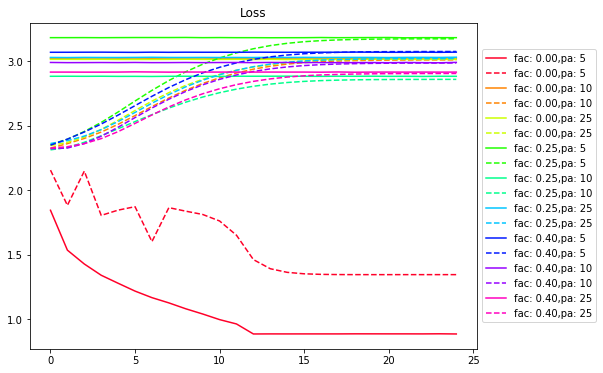

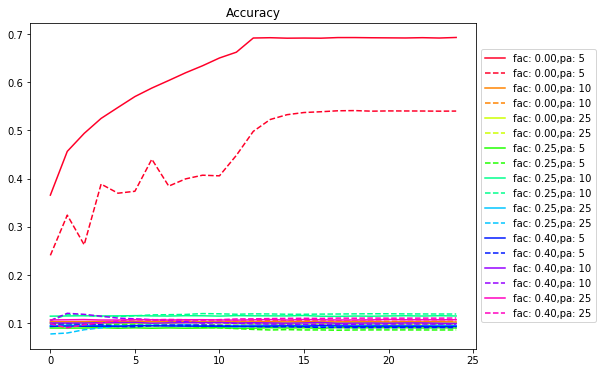

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()